<a href="https://colab.research.google.com/github/mazzingkaizer/pytorch_n_fastai_examples/blob/master/fastbook/06_multicat_20200929_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
!nvidia-smi

In [ ]:
#hide
from fastbook import *

[[chapter_multicat]]

# Other Computer Vision Problems

이전 장에서 실제로 모델을 훈련하기위한 몇 가지 중요한 실용적인 기술을 배웠습니다. 좋은 결과를 얻으려면 학습률 및 에포크 수 선택과 같은 고려 사항이 매우 중요합니다.

이 장에서는 다른 두 가지 유형의 컴퓨터 비전 문제인 다중 레이블 분류와 회귀를 살펴볼 것입니다. 첫 번째는 이미지 당 하나 이상의 레이블을 예측하려는 경우 (또는 때로는 전혀 없음)이고 두 번째는 레이블이 범주 대신 수량 인 하나 또는 여러 숫자 인 경우입니다.

이 과정에서 딥 러닝 모델의 출력 활성화, 목표 및 손실 함수를 더 깊이 연구합니다.

## Multi-Label Classification

다중 레이블 분류는 정확히 한 가지 유형의 객체를 포함하지 않을 수있는 이미지의 객체 범주를 식별하는 문제를 나타냅니다. 여러 종류의 개체가 있거나 찾고있는 클래스에 개체가 전혀 없을 수 있습니다.

예를 들어, 이것은 우리 곰 분류기에 대한 훌륭한 접근 방식이었을 것입니다. << chapter_production >>에서 출시 한 곰 분류기의 한 가지 문제는 사용자가 어떤 종류의 곰도 아닌 것을 업로드해도 모델은 여전히 ​​회색, 검은 색 또는 곰 인형이라고 말합니다. "전혀 곰이 아님"을 예측할 능력이 없었습니다. 실제로이 장을 완료 한 후에는 이미지 분류기 응용 프로그램으로 돌아가서 다중 레이블 기술을 사용하여 다시 훈련 한 다음 당신이 인정한 수업 중에 그렇지 않은 이미지를 전달하여 테스트하는 것이 좋습니다. 

실제로 이러한 목적으로 다중 레이블 분류기를 훈련하는 사람들의 예는 많지 않지만 사용자와 개발자 모두이 문제에 대해 불평하는 경우가 많습니다. 이 간단한 해결책은 널리 이해되거나 평가되지 않는 것 같습니다! 실제로는 일치하는 이미지가 없거나 일치하는 이미지가 두 개 이상있는 이미지가 더 일반적 일 수 있으므로 실제로는 다중 레이블 분류 기가 단일 레이블 분류기보다 더 광범위하게 적용된다는 것을 예상해야합니다.

먼저 다중 레이블 데이터 세트가 어떻게 생겼는지 살펴본 다음 모델에 맞게 준비하는 방법을 설명하겠습니다. 모델의 아키텍처가 지난 장에서 변경되지 않음을 알 수 있습니다. 손실 함수 만 수행합니다. 데이터부터 시작하겠습니다.

### The Data

이 예에서는 이미지 당 여러 종류의 분류 된 개체를 가질 수있는 PASCAL 데이터 세트를 사용합니다.

평소대로 데이터 세트를 다운로드하고 추출하는 것으로 시작합니다.

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

이 데이터 세트는 파일 이름이나 폴더로 구조화되지 않고 대신 각 이미지에 사용할 라벨을 알려주는 CSV (쉼표로 구분 된 값) 파일과 함께 제공된다는 점에서 이전에 본 데이터 세트와 다릅니다. CSV 파일을 Pandas DataFrame으로 읽어서 검사 할 수 있습니다.

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


보시다시피 각 이미지의 카테고리 목록은 공백으로 구분 된 문자열로 표시됩니다.

### Sidebar: Pandas and DataFrames

아니, 사실 판다가 아니야! * Pandas *는 테이블 형식 및 시계열 데이터를 조작하고 분석하는 데 사용되는 Python 라이브러리입니다. 메인 클래스는 행과 열의 테이블을 나타내는`DataFrame`입니다. CSV 파일, 데이터베이스 테이블, Python 사전 및 기타 여러 소스에서 DataFrame을 가져올 수 있습니다. Jupyter에서 DataFrame은 여기에 표시된 것처럼 형식이 지정된 테이블로 출력됩니다.

`iloc` 속성을 사용하여 마치 행렬 인 것처럼 DataFrame의 행과 열에 액세스 할 수 있습니다.

In [ ]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [ ]:
df.iloc[0,:]
# T후행 : s는 항상 선택 사항 (numpy, pytorch, pandas 등)이므로 다음과 같습니다.
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

DataFrame에 직접 인덱싱하여 이름별로 열을 가져올 수도 있습니다.

In [ ]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

새 열을 만들고 열을 사용하여 계산을 수행 할 수 있습니다.

In [ ]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [ ]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


Pandas는 빠르고 유연한 라이브러리이며 모든 데이터 과학자의 Python 도구 상자에서 중요한 부분입니다. 안타깝게도 API는 다소 혼란스럽고 놀랍기 때문에 익숙해지는 데 시간이 걸립니다. 이전에 Pandas를 사용해 본 적이 없다면 튜토리얼을 진행하는 것이 좋습니다. 우리는 특히 Pandas (O'Reilly)의 창시자 인 Wes McKinney의 [* Python for Data Analysis *] (http://shop.oreilly.com/product/0636920023784.do) 책을 좋아합니다. 또한`matplotlib` 및`numpy`와 같은 다른 중요한 라이브러리도 다룹니다. 우리가 사용하는 Pandas 기능에 대해 간단히 설명하려고하지만 McKinney의 책의 세부 수준은 다루지 않겠습니다.

### End sidebar

이제 데이터가 어떻게 생겼는지 확인 했으므로 모델 학습을 위해 준비해 보겠습니다.

### Constructing a DataBlock

`DataFrame` 객체에서`DataLoaders` 객체로 어떻게 변환합니까? 일반적으로 가능한 경우 데이터 블록 API를 사용하여 'DataLoaders'개체를 만드는 것이 좋습니다. 유연성과 단순성이 잘 혼합되어 있기 때문입니다. 여기서는 데이터 블록 API를 사용하여 실제로 'DataLoaders'개체를 생성하는 단계를 보여줍니다.이 데이터 세트를 예로 들어 설명합니다.

지금까지 살펴본 것처럼 PyTorch와 fastai에는 훈련 세트 또는 검증 세트를 나타내고 액세스하기위한 두 가지 주요 클래스가 있습니다.

- `Dataset`:: 단일 항목에 대한 독립 및 종속 변수의 튜플을 반환하는 컬렉션
- `DataLoader`:: 미니 배치 스트림을 제공하는 반복기입니다. 여기서 각 미니 배치는 독립 변수 배치와 종속 변수 배치의 튜플입니다.

이외에도 fastai는 교육 및 검증 세트를 함께 가져 오는 두 가지 클래스를 제공합니다.

- `Datasets`:: 학습 'Dataset'및 유효성 검사 'Dataset'를 포함하는 객체
- `DataLoaders`:: 학습 'DataLoader'및 유효성 검사 'DataLoader'를 포함하는 개체

`DataLoader`는`Dataset` 위에 빌드되고 추가 기능을 추가하기 때문에 (여러 항목을 미니 배치로 조합),`Datasets`를 만들고 테스트 한 다음`DataLoaders`를 살펴 보는 것이 가장 쉬운 경우가 많습니다. 그 후 작동합니다.

'DataBlock'을 만들 때 단계적으로 점진적으로 구축하고 노트북을 사용하여 데이터를 확인합니다. 이것은 코딩하는 동안 추진력을 유지하고 문제가 있는지 주시 할 수있는 좋은 방법입니다. 문제가 발생하면 방금 입력 한 코드 줄에 있다는 것을 알기 때문에 디버그하기 쉽습니다.

매개 변수없이 생성 된 데이터 블록 인 가장 간단한 경우부터 시작하겠습니다.

In [ ]:
dblock = DataBlock()

여기에서`Datasets` 객체를 만들 수 있습니다. 필요한 것은 소스입니다.이 경우에는 DataFrame입니다.

In [ ]:
dsets = dblock.datasets(df)

여기에는 'train'과 'valid' dataset가 포함되며 다음과 같이 색인을 생성 할 수 있습니다.

In [ ]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [ ]:
x,y = dsets.train[0]
x,y

(fname              005686.jpg
 labels      chair diningtable
 is_valid                False
 Name: 2854, dtype: object,
 fname              005686.jpg
 labels      chair diningtable
 is_valid                False
 Name: 2854, dtype: object)

보시다시피 이것은 단순히 DataFrame의 행을 두 번 반환합니다. 이는 기본적으로 데이터 블록이 입력과 대상이라는 두 가지 항목이 있다고 가정하기 때문입니다. DataFrame에서 적절한 필드를 가져와야합니다. 'get_x'및 'get_y'함수를 전달하여 수행 할 수 있습니다.

In [ ]:
x['fname']

'005686.jpg'

In [ ]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('006772.jpg', 'person')

보시다시피 일반적인 방식으로 함수를 정의하는 대신 Python의`lambda` 키워드를 사용하고 있습니다. 이것은 함수를 정의하고 참조하기위한 지름길 일뿐입니다. 다음과 같은보다 자세한 접근 방식은 동일합니다.

In [ ]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('009468.jpg', 'horse person')

Lambda 함수는 빠르게 반복하는 데 적합하지만 직렬화와 호환되지 않으므로 훈련 후 'Learner'를 내보내려는 경우 더 자세한 접근 방식을 사용하는 것이 좋습니다 (실험 만하는 경우 람다는 괜찮음).

독립 변수는 이미지로 열 수 있도록 완전한 경로로 변환되어야하며 종속 변수는 공백 문자로 분할되어야합니다 (파이썬의 '분할'의 기본값입니다). 함수) 목록이되도록 :

In [ ]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/000113.jpg'), ['person'])

실제로 이미지를 열고 텐서로 변환하려면 변환 세트를 사용해야합니다. 블록 유형이이를 제공합니다. 이전에 사용한 것과 동일한 블록 유형을 사용할 수 있지만 한 가지 예외가 있습니다. 유효한 이미지를 가리키는 경로가 있기 때문에`ImageBlock`이 다시 정상적으로 작동하지만`CategoryBlock`은 작동하지 않습니다. 문제는 블록이 단일 정수를 반환하지만 각 항목에 대해 여러 레이블을 가질 수 있어야한다는 것입니다. 이를 해결하기 위해`MultiCategoryBlock`을 사용합니다. 이 유형의 블록은이 경우처럼 문자열 목록을 수신 할 것으로 예상하므로 테스트 해 보겠습니다.

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x423,
 TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

보시다시피, 카테고리 목록은 일반 'CategoryBlock'과 동일한 방식으로 인코딩되지 않습니다. 이 경우 우리는 어휘에서의 위치에 따라 어떤 범주가 존재하는지 나타내는 단일 정수를 가졌습니다. 그러나이 경우에는 대신 해당 범주가있는 모든 위치에 1이있는 0 목록이 있습니다. 예를 들어, 두 번째와 네 번째 위치에 하나가 있으면이 이미지에 단어 항목 2와 4가 있음을 의미합니다. 이를 * 원-핫 인코딩 *이라고합니다. 카테고리 색인 목록을 쉽게 사용할 수없는 이유는 각 목록의 길이가 다르고 PyTorch에는 모든 길이가 같아야하는 텐서가 필요하기 때문입니다.

> 전문 용어 : 원-핫 인코딩 : 데이터에 표시되는 각 위치에 1이있는 0 벡터를 사용하여 정수 목록을 인코딩합니다.

이 예에서 카테고리가 나타내는 것이 무엇인지 확인해 보겠습니다 (조건이 참 또는 거짓 인 모든 인덱스를 알려주는 편리한`torch.where` 함수를 사용하고 있습니다).

In [ ]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['bird']

NumPy 배열, PyTorch 텐서 및 fastai의 'L'클래스를 사용하면 목록 또는 벡터를 사용하여 직접 인덱싱 할 수 있으므로 많은 코드 (예 :이 예)를 훨씬 더 명확하고 간결하게 만들 수 있습니다.

지금까지`is_valid` 열을 무시했습니다. 이는`DataBlock`이 기본적으로 무작위 분할을 사용하고 있음을 의미합니다. 유효성 검사 세트의 요소를 명시 적으로 선택하려면 함수를 작성하고 'splitter'에 전달해야합니다 (또는 fastai의 미리 정의 된 함수 또는 클래스 중 하나를 사용). 항목 (여기서는 전체 DataFrame)을 가져 와서 두 개 이상의 정수 목록을 반환해야합니다.

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

앞서 논의했듯이`DataLoader`는`Dataset`의 항목을 미니 배치로 수집합니다. 이것은 텐서의 튜플이며, 각 텐서는 단순히`Dataset` 항목의 해당 위치에서 항목을 스택합니다.

이제 개별 항목이 괜찮아 보이는지 확인 했으므로 'DataLoaders'를 만들 수 있는지 확인해야하는 단계가 하나 더 있습니다. 이는 모든 항목이 동일한 크기인지 확인하는 것입니다. 이를 위해`RandomResizedCrop`을 사용할 수 있습니다.

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

이제 데이터 샘플을 표시 할 수 있습니다.

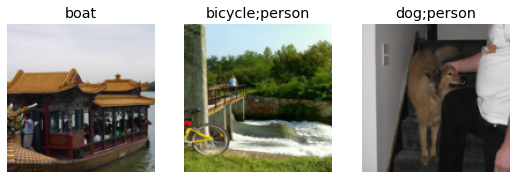

In [ ]:
dls.show_batch(nrows=1, ncols=3)

`DataBlock`에서`DataLoaders`를 생성 할 때 문제가 발생하거나`DataBlock`에서 어떤 일이 발생하는지 정확히보고 싶다면 지난 장에서 설명한`summary` 메서드를 사용할 수 있습니다.

이제 데이터가 모델을 학습 할 준비가되었습니다. 보시다시피, 우리가 'Learner'를 만들 때 아무것도 바뀌지 않을 것이지만, 그 뒤에서 fastai 라이브러리는 새로운 손실 함수 인 바이너리 크로스 엔트로피를 선택할 것입니다.

### Binary Cross-Entropy

Now we'll create our `Learner`. We saw in <<chapter_mnist_basics>> that a `Learner` object contains four main things: the model, a `DataLoaders` object, an `Optimizer`, and the loss function to use. We already have our `DataLoaders`, we can leverage fastai's `resnet` models (which we'll learn how to create from scratch later), and we know how to create an `SGD` optimizer. So let's focus on ensuring we have a suitable loss function. To do this, let's use `cnn_learner` to create a `Learner`, so we can look at its activations:

In [ ]:
learn = cnn_learner(dls, resnet18)

We also saw that the model in a `Learner` is generally an object of a class inheriting from `nn.Module`, and that we can call it using parentheses and it will return the activations of a model. You should pass it your independent variable, as a mini-batch. We can try it out by grabbing a mini batch from our `DataLoader` and then passing it to the model:

In [ ]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

Think about why `activs` has this shape—we have a batch size of 64, and we need to calculate the probability of each of 20 categories. Here’s what one of those activations looks like:

In [ ]:
activs[0]

tensor([ 2.2812,  0.8778, -1.1049,  0.6349, -1.3902,  1.5965, -2.1234, -2.5194,  0.4696, -2.8341, -0.8314, -2.1650, -1.4232, -1.6563, -0.8089,  0.8098,  4.4866,  0.6670,  2.7531, -2.0070],
       grad_fn=<SelectBackward>)

> note: Getting Model Activations: Knowing how to manually get a mini-batch and pass it into a model, and look at the activations and loss, is really important for debugging your model. It is also very helpful for learning, so that you can see exactly what is going on.

They aren’t yet scaled to between 0 and 1, but we learned how to do that in <<chapter_mnist_basics>>, using the `sigmoid` function. We also saw how to calculate a loss based on this—this is our loss function from <<chapter_mnist_basics>>, with the addition of `log` as discussed in the last chapter:

In [ ]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

Note that because we have a one-hot-encoded dependent variable, we can't directly use `nll_loss` or `softmax` (and therefore we can't use `cross_entropy`):

- `softmax`, as we saw, requires that all predictions sum to 1, and tends to push one activation to be much larger than the others (due to the use of `exp`); however, we may well have multiple objects that we're confident appear in an image, so restricting the maximum sum of activations to 1 is not a good idea. By the same reasoning, we may want the sum to be *less* than 1, if we don't think *any* of the categories appear in an image.
- `nll_loss`, as we saw, returns the value of just one activation: the single activation corresponding with the single label for an item. This doesn't make sense when we have multiple labels.

On the other hand, the `binary_cross_entropy` function, which is just `mnist_loss` along with `log`, provides just what we need, thanks to the magic of PyTorch's elementwise operations. Each activation will be compared to each target for each column, so we don't have to do anything to make this function work for multiple columns.

> j: One of the things I really like about working with libraries like PyTorch, with broadcasting and elementwise operations, is that quite frequently I find I can write code that works equally well for a single item or a batch of items, without changes. `binary_cross_entropy` is a great example of this. By using these operations, we don't have to write loops ourselves, and can rely on PyTorch to do the looping we need as appropriate for the rank of the tensors we're working with.

PyTorch already provides this function for us. In fact, it provides a number of versions, with rather confusing names!

`F.binary_cross_entropy` and its module equivalent `nn.BCELoss` calculate cross-entropy on a one-hot-encoded target, but do not include the initial `sigmoid`. Normally for one-hot-encoded targets you'll want `F.binary_cross_entropy_with_logits` (or `nn.BCEWithLogitsLoss`), which do both sigmoid and binary cross-entropy in a single function, as in the preceding example.

The equivalent for single-label datasets (like MNIST or the Pet dataset), where the target is encoded as a single integer, is `F.nll_loss` or `nn.NLLLoss` for the version without the initial softmax, and `F.cross_entropy` or `nn.CrossEntropyLoss` for the version with the initial softmax.

Since we have a one-hot-encoded target, we will use `BCEWithLogitsLoss`:

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0473, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

We don't actually need to tell fastai to use this loss function (although we can if we want) since it will be automatically chosen for us. fastai knows that the `DataLoaders` has multiple category labels, so it will use `nn.BCEWithLogitsLoss` by default.

One change compared to the last chapter is the metric we use: because this is a multilabel problem, we can't use the accuracy function. Why is that? Well, accuracy was comparing our outputs to our targets like so:

```python
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()
```

The class predicted was the one with the highest activation (this is what `argmax` does). Here it doesn't work because we could have more than one prediction on a single image. After applying the sigmoid to our activations (to make them between 0 and 1), we need to decide which ones are 0s and which ones are 1s by picking a *threshold*. Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0:

```python
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
```

If we pass `accuracy_multi` directly as a metric, it will use the default value for `threshold`, which is 0.5. We might want to adjust that default and create a new version of `accuracy_multi` that has a different default. To help with this, there is a function in Python called `partial`. It allows us to *bind* a function with some arguments or keyword arguments, making a new version of that function that, whenever it is called, always includes those arguments. For instance, here is a simple function taking two arguments:

In [ ]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

We can switch to a French version of that function by using `partial`:

In [ ]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

We can now train our model. Let's try setting the accuracy threshold to 0.2 for our metric:

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.947724,0.695100,0.238765,00:09
1,0.824979,0.562302,0.299143,00:08
2,0.605748,0.204235,0.817391,00:10
3,0.361469,0.122939,0.940697,00:11


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.134300,0.117387,0.942351,00:15
1,0.116927,0.107425,0.950637,00:16
2,0.097333,0.103406,0.952610,00:15


Picking a threshold is important. If you pick a threshold that's too low, you'll often be failing to select correctly labeled objects. We can see this by changing our metric, and then calling `validate`, which returns the validation loss and metrics:

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10340561717748642,0.9329284429550171]

If you pick a threshold that's too high, you'll only be selecting the objects for which your model is very confident:

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10340561717748642,0.94420325756073]

We can find the best threshold by trying a few levels and seeing what works best. This is much faster if we just grab the predictions once:

In [ ]:
preds,targs = learn.get_preds()

Then we can call the metric directly. Note that by default `get_preds` applies the output activation function (sigmoid, in this case) for us, so we'll need to tell `accuracy_multi` to not apply it:

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9577)

We can now use this approach to find the best threshold level:

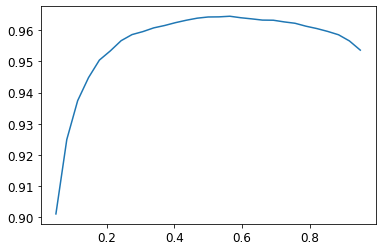

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In this case, we're using the validation set to pick a hyperparameter (the threshold), which is the purpose of the validation set. Sometimes students have expressed their concern that we might be *overfitting* to the validation set, since we're trying lots of values to see which is the best. However, as you see in the plot, changing the threshold in this case results in a smooth curve, so we're clearly not picking some inappropriate outlier. This is a good example of where you have to be careful of the difference between theory (don't try lots of hyperparameter values or you might overfit the validation set) versus practice (if the relationship is smooth, then it's fine to do this).

This concludes the part of this chapter dedicated to multi-label classification. Next, we'll take a look at a regression problem.

## Regression

It's easy to think of deep learning models as being classified into domains, like *computer vision*, *NLP*, and so forth. And indeed, that's how fastai classifies its applications—largely because that's how most people are used to thinking of things.

But really, that's hiding a more interesting and deeper perspective. A model is defined by its independent and dependent variables, along with its loss function. That means that there's really a far wider array of models than just the simple domain-based split. Perhaps we have an independent variable that's an image, and a dependent that's text (e.g., generating a caption from an image); or perhaps we have an independent variable that's text and dependent that's an image (e.g., generating an image from a caption—which is actually possible for deep learning to do!); or perhaps we've got images, texts, and tabular data as independent variables, and we're trying to predict product purchases... the possibilities really are endless.

To be able to move beyond fixed applications, to crafting your own novel solutions to novel problems, it helps to really understand the data block API (and maybe also the mid-tier API, which we'll see later in the book). As an example, let's consider the problem of *image regression*. This refers to learning from a dataset where the independent variable is an image, and the dependent variable is one or more floats. Often we see people treat image regression as a whole separate application—but as you'll see here, we can treat it as just another CNN on top of the data block API.

We're going to jump straight to a somewhat tricky variant of image regression, because we know you're ready for it! We're going to do a key point model. A *key point* refers to a specific location represented in an image—in this case, we'll use images of people and we'll be looking for the center of the person's face in each image. That means we'll actually be predicting *two* values for each image: the row and column of the face center. 

### Assemble the Data

We will use the [Biwi Kinect Head Pose dataset](https://icu.ee.ethz.ch/research/datsets.html) for this section. We'll begin by downloading the dataset as usual:

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
#hide
Path.BASE_PATH = path

Let's see what we've got!

In [ ]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

There are 24 directories numbered from 01 to 24 (they correspond to the different people photographed), and a corresponding *.obj* file for each (we won't need them here). Let's take a look inside one of these directories:

In [ ]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

Inside the subdirectories, we have different frames, each of them come with an image (*\_rgb.jpg*) and a pose file (*\_pose.txt*). We can easily get all the image files recursively with `get_image_files`, then write a function that converts an image filename to its associated pose file:

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('06/frame_00113_pose.txt')

Let's take a look at our first image:

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

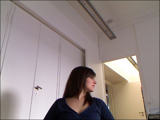

In [ ]:
im.to_thumb(160)

The Biwi dataset website used to explain the format of the pose text file associated with each image, which shows the location of the center of the head. The details of this aren't important for our purposes, so we'll just show the function we use to extract the head center point:

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

This function returns the coordinates as a tensor of two items:

In [ ]:
get_ctr(img_files[0])

tensor([379.1756, 318.0512])

We can pass this function to `DataBlock` as `get_y`, since it is responsible for labeling each item. We'll resize the images to half their input size, just to speed up training a bit.

One important point to note is that we should not just use a random splitter. The reason for this is that the same people appears in multiple images in this dataset, but we want to ensure that our model can generalize to people that it hasn't seen yet. Each folder in the dataset contains the images for one person. Therefore, we can create a splitter function that returns true for just one person, resulting in a validation set containing just that person's images.

The only other difference tfrom the previous data block examples is that the second block is a `PointBlock`. This is necessary so that fastai knows that the labels represent coordinates; that way, it knows that when doing data augmentation, it should do the same augmentation to these coordinates as it does to the images:

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

> important: Points and Data Augmentation: We're not aware of other libraries (except for fastai) that automatically and correctly apply data augmentation to coordinates. So, if you're working with another library, you may need to disable data augmentation for these kinds of problems.

Before doing any modeling, we should look at our data to confirm it seems okay:

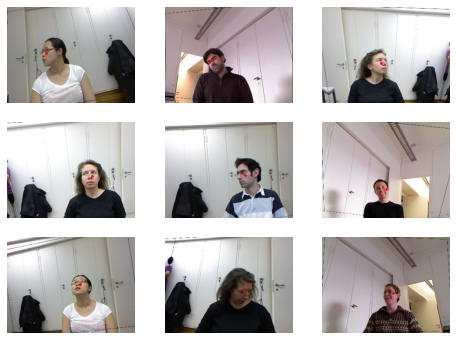

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

That's looking good! As well as looking at the batch visually, it's a good idea to also look at the underlying tensors (especially as a student; it will help clarify your understanding of what your model is really seeing):

In [ ]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

Make sure that you understand *why* these are the shapes for our mini-batches.

Here's an example of one row from the dependent variable:

In [ ]:
yb[0]

tensor([[-0.1476,  0.2720]], device='cuda:0')

As you can see, we haven't had to use a separate *image regression* application; all we've had to do is label the data, and tell fastai what kinds of data the independent and dependent variables represent.

It's the same for creating our `Learner`. We will use the same function as before, with one new parameter, and we will be ready to train our model.

### Training a Model

As usual, we can use `cnn_learner` to create our `Learner`. Remember way back in <<chapter_intro>> how we used `y_range` to tell fastai the range of our targets? We'll do the same here (coordinates in fastai and PyTorch are always rescaled between -1 and +1):

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

`y_range` is implemented in fastai using `sigmoid_range`, which is defined as:

In [ ]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

This is set as the final layer of the model, if `y_range` is defined. Take a moment to think about what this function does, and why it forces the model to output activations in the range `(lo,hi)`.

Here's what it looks like:

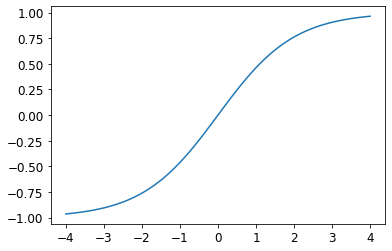

In [ ]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

We didn't specify a loss function, which means we're getting whatever fastai chooses as the default. Let's see what it picked for us:

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

This makes sense, since when coordinates are used as the dependent variable, most of the time we're likely to be trying to predict something as close as possible; that's basically what `MSELoss` (mean squared error loss) does. If you want to use a different loss function, you can pass it to `cnn_learner` using the `loss_func` parameter.

Note also that we didn't specify any metrics. That's because the MSE is already a useful metric for this task (although it's probably more interpretable after we take the square root). 

We can pick a good learning rate with the learning rate finder:

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.004365158267319202)

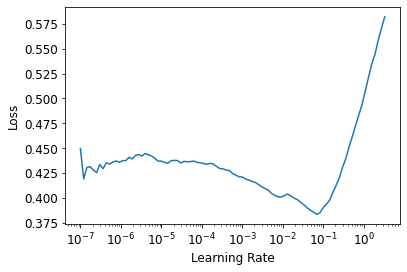

In [ ]:
learn.lr_find()

We'll try an LR of 2e-2:

In [ ]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.048322,0.008876,01:21


epoch,train_loss,valid_loss,time
0,0.008702,0.001858,01:43
1,0.003161,0.000490,01:39
2,0.001513,0.000072,01:48


Generally when we run this we get a loss of around 0.0001, which corresponds to an average coordinate prediction error of:

In [ ]:
math.sqrt(0.0001)

0.01

This sounds very accurate! But it's important to take a look at our results with `Learner.show_results`. The left side are the actual (*ground truth*) coordinates and the right side are our model's predictions:

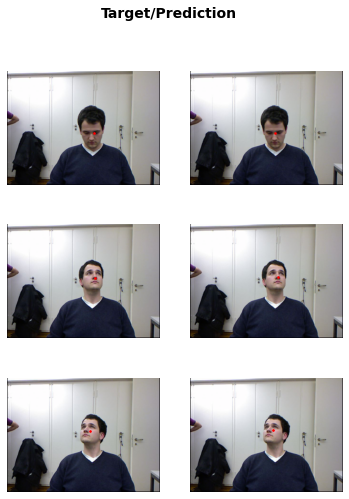

In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

It's quite amazing that with just a few minutes of computation we've created such an accurate key points model, and without any special domain-specific application. This is the power of building on flexible APIs, and using transfer learning! It's particularly striking that we've been able to use transfer learning so effectively even between totally different tasks; our pretrained model was trained to do image classification, and we fine-tuned for image regression.

## Conclusion

In problems that are at first glance completely different (single-label classification, multi-label classification, and regression), we end up using the same model with just different numbers of outputs. The loss function is the one thing that changes, which is why it's important to double-check that you are using the right loss function for your problem.

fastai will automatically try to pick the right one from the data you built, but if you are using pure PyTorch to build your `DataLoader`s, make sure you think hard when you have to decide on your about your choice of loss function, and remember that you most probably want:

- `nn.CrossEntropyLoss` for single-label classification
- `nn.BCEWithLogitsLoss` for multi-label classification
- `nn.MSELoss` for regression

## Questionnaire

1. 다중 라벨 분류가 곰 분류기의 유용성을 어떻게 향상시킬 수 있습니까?
1. 다중 레이블 분류 문제에서 종속 변수를 어떻게 인코딩합니까?
1. 마치 행렬 인 것처럼 DataFrame의 행과 열에 어떻게 액세스합니까?
1. DataFrame에서 이름으로 열을 가져 오는 방법은 무엇입니까?
1.`Dataset`과`DataLoader`의 차이점은 무엇입니까?
1.`Datasets` 객체는 일반적으로 무엇을 포함합니까?
1.`DataLoaders` 객체에는 일반적으로 무엇이 포함됩니까?
1. 파이썬에서`lambda`는 무엇을합니까?
1. 데이터 블록 API로 독립 변수와 종속 변수를 생성하는 방법을 사용자 정의하는 방법은 무엇입니까?
1. 핫 인코딩 된 하나의 타겟을 사용할 때 소프트 맥스가 적절한 출력 활성화 기능이 아닌 이유는 무엇입니까?
1. 원-핫 인코딩 대상을 사용할 때`nll_loss`가 적절한 손실 함수가 아닌 이유는 무엇입니까?
1.`nn.BCELoss`와`nn.BCEWithLogitsLoss`의 차이점은 무엇입니까?
1. 다중 레이블 문제에서 규칙적인 정확도를 사용할 수없는 이유는 무엇입니까?
1. 검증 세트에서 하이퍼 파라미터를 조정하는 것은 언제 괜찮습니까?
1. fastai에서`y_range`는 어떻게 구현됩니까? (직접 구현하고 엿보기없이 테스트 할 수 있는지 확인하십시오!)
1. 회귀 문제는 무엇입니까? 이러한 문제에 대해 어떤 손실 함수를 사용해야합니까?
1. fastai 라이브러리가 입력 이미지와 목표 지점 좌표에 동일한 데이터 증가를 적용하려면 어떻게해야합니까?

### Further Research

1. Pandas DataFrames에 대한 자습서를 읽고 흥미로운 몇 가지 방법을 실험 해보십시오. 권장 튜토리얼은 책의 웹 사이트를 참조하십시오.
1. 다중 레이블 분류를 사용하여 곰 분류기를 다시 훈련시킵니다. 웹 애플리케이션에서 해당 정보를 표시하는 것을 포함하여 곰이 포함되지 않은 이미지로 효과적으로 작동 할 수 있는지 확인하십시오. 두 종류의 곰이있는 이미지를 시도해보세요. 단일 라벨 데이터 세트의 정확성이 다중 라벨 분류를 사용하여 영향을 받는지 확인합니다.